<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Data Visualisation avec Python: Introduction au Plotly - Dash</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Visualisation de graphiques interactifs avec plotly
</h2>
</div>

# Objectifs
Ce notebook vise à vous familiariser avec la visualisation de graphiques interactifs à l'aide de Plotly et Dash avec l'ensemble de données Olist e-commerce.

1. JOUR 1: Analyse des données et Plotly
- Collecter des données à partir de la base de données Olist
- Nettoyer, fusionner et préparer des ensembles de données prêts à l'emploi
- Calculer les indicateurs clés de performance : ventes, avis, délais de livraison
- Créer des graphiques interactifs avec Plotly (lignes, barres, histogrammes, cartes).

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.1 - Importation des librairies</h3>
</div>

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sqlite3

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.2 - Connection à la base de données Olist</h3>
</div>

In [165]:
conn = sqlite3.connect('/Users/BabouMbaye/PycharmProjects/Olist_Project/data/olist.db')

In [166]:
df_fact = pd.read_sql_query("""
SELECT
    o.order_id,
    o.customer_id,
    c.customer_unique_id,
    c.customer_city,
    c.customer_state,

    o.order_status,
    o.order_purchase_timestamp,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,

    oi.product_id,
    t.product_category_name_english as product_category_name,
    oi.price,
    oi.freight_value,

    r.review_score,
    op.payment_type,
    op.payment_installments,
    op.payment_value
FROM orders o
LEFT JOIN customers c
    ON o.customer_id = c.customer_id
LEFT JOIN order_items oi
    ON o.order_id = oi.order_id
LEFT JOIN products p
    ON oi.product_id = p.product_id
LEFT JOIN order_reviews r
    ON o.order_id = r.order_id
LEFT JOIN order_pymts op
    ON o.order_id = op.order_id
left join translation t on t.product_category_name = p.product_category_name
""", conn)

In [167]:
df_fact.head()

,order_id,customer_id,customer_unique_id,customer_city,customer_state,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,price,freight_value,review_score,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,4.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,4.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,housewares,29.99,8.72,4.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,BA,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,perfumery,118.70,22.76,4.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,auto,159.90,19.22,5.0,credit_card,3.0,179.12


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.4 - Préparation des données</h3>
</div>

In [196]:
df_fact["order_purchase_timestamp"] = pd.to_datetime(df_fact["order_purchase_timestamp"])
df_fact["order_month"] = df_fact["order_purchase_timestamp"].dt.to_period("M").astype(str)

df_fact["total_price"] = df_fact["price"] + df_fact["freight_value"]

df_fact["delivery_time"] = (
    pd.to_datetime(df_fact["order_delivered_customer_date"]) 
    - df_fact["order_purchase_timestamp"]   
).dt.days

df_fact['delivery_vs_estimate'] = (
            pd.to_datetime(df_fact['order_delivered_customer_date']) -
            pd.to_datetime(df_fact['order_estimated_delivery_date'])
    ).dt.days
df_fact["order_weekday"] = df_fact["order_purchase_timestamp"].dt.day_name()
df_fact["order_weekday_num"] = df_fact["order_purchase_timestamp"].dt.weekday
df_fact["order_quater"] = df_fact["order_purchase_timestamp"].dt.quarter
df_fact["order_year"] = df_fact["order_purchase_timestamp"].dt.year
df_fact["order_hour"] = df_fact["order_purchase_timestamp"].dt.hour



In [197]:
df_fact.head()

,order_id,customer_id,customer_unique_id,customer_city,customer_state,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,...,payment_value,order_month,total_price,delivery_time,delivery_vs_estimate,order_weekday,order_quater,order_year,order_hour,order_weekday_num
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,...,18.12,2017-10,38.71,8.0,-8.0,Monday,4,2017,10,0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,...,2.00,2017-10,38.71,8.0,-8.0,Monday,4,2017,10,0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,...,18.59,2017-10,38.71,8.0,-8.0,Monday,4,2017,10,0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,BA,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,595fac2a385ac33a80bd5114aec74eb8,...,141.46,2018-07,141.46,13.0,-6.0,Tuesday,3,2018,20,1
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,aa4383b373c6aca5d8797843e5594415,...,179.12,2018-08,179.12,9.0,-18.0,Wednesday,3,2018,8,2


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2 - Vue d'ensemble</h3>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.1 - Calcul des indicateurs de performance</h3>
</div>

In [198]:
# 2.9 Nombre de clients total
total_customers = df_fact["customer_unique_id"].nunique()
print(f"Nombre total de clients : {total_customers}")

# 2.10 Nombre d'orders total
total_orders = df_fact["order_id"].nunique()
print(f"Nombre total d'orders : {total_orders}")
# 2.11 Nombre de produits total vendus
total_products = df_fact["product_id"].nunique()
print(f"Nombre total de produits vendus : {total_products}")

# 2.12 Nombre total de commandes livrées
total_delivered_orders = df_fact[df_fact["order_status"]=="delivered"]["order_id"].nunique()
print(f"Nombre total de commandes livrées : {total_delivered_orders}")
# 2.13 Nombre total de commandes annulées
total_canceled_orders = (df_fact["order_status"]=="canceled").sum()
print(f"Nombre total de commandes annulées : {total_canceled_orders}")
# Chiffre d'affaire total
total_revenue = df_fact["total_price"].sum()
print(f"Chiffre d'affaire total : {total_revenue.round(2)}")
# Panier moyen par client
avg_cart_size = df_fact.groupby("customer_unique_id")["total_price"].sum().mean()
print(f"Panier moyen par client : {avg_cart_size.round(2)}")
# Note moyenne des commandes
avg_review = df_fact["review_score"].mean()
print(f"Note moyenne des commandes : {avg_review.round(2)}")
# taux de commandes annulées
canceled_rate = total_canceled_orders / total_orders * 100
print(f"Taux de commandes annulées : {canceled_rate.round(2)} %")
# Taux de commandes livrées
delivered_rate = total_delivered_orders / total_orders * 100.0
print(f"Taux de commandes livrées : {np.round(delivered_rate,2)} %")

Nombre total de clients : 96096
Nombre total d'orders : 99441
Nombre total de produits vendus : 32951
Nombre total de commandes livrées : 96478
Nombre total de commandes annulées : 750
Chiffre d'affaire total : 16643731.3
Panier moyen par client : 173.2
Note moyenne des commandes : 4.02
Taux de commandes annulées : 0.75 %
Taux de commandes livrées : 97.02 %


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.2 - Visualisation</h3>
</div>

In [199]:
# 2.2.1 - Ventes mensuelles
monthly_sales = df_fact.groupby("order_month")["total_price"].sum()
display(monthly_sales.reset_index())

,order_month,total_price
0,2016-09,354.75
1,2016-10,58730.85
2,2016-12,19.62
3,2017-01,148030.11
4,2017-02,303648.31
5,2017-03,459778.64
6,2017-04,449707.81
7,2017-05,634762.22
8,2017-06,531052.06
9,2017-07,631341.57


In [200]:
# 2.2.1 - graphique des ventes mensuelles
fig1 = px.line(monthly_sales.reset_index(), x="order_month", y="total_price", title="Ventes mensuelles")
fig1.show()

In [201]:
# 2.2.2 - Distribution des commande par status
order_status_count = df_fact.groupby("order_status")["order_id"].nunique()
display(order_status_count.reset_index())

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [202]:
# 2.2.2 - graphique de la distribution des commandes par status
fig2 = px.pie(order_status_count.reset_index(), names="order_status", values="order_id", title="Distribution des commandes par status")
fig2.show()

In [203]:
# 2.2.3 - Top 10 des catégories par CA
top_categories = df_fact.groupby("product_category_name")["total_price"].sum().sort_values(ascending=False)
display(top_categories.reset_index().head(10))

,product_category_name,total_price
0,health_beauty,1491397.76
1,watches_gifts,1358845.59
2,bed_bath_table,1327662.02
3,sports_leisure,1205197.85
4,computers_accessories,1104362.03
5,furniture_decor,955367.22
6,housewares,823623.50
7,cool_stuff,752702.21
8,auto,714431.95
9,garden_tools,625387.31


In [204]:
# 2.2.3 - graphique des top 10 des catégories par CA
fig3 = px.bar(top_categories.reset_index().head(10), x="product_category_name", y="total_price", title="Top 10 des catégories par CA")
fig3.show()

In [205]:
# 2.4 - Temps de livraison moyen
top_etat_par_ca = df_fact.groupby(["customer_state"])["total_price"].sum().sort_values(ascending=False)
display(top_etat_par_ca.reset_index().head(10))

,customer_state,total_price
0,SP,6234533.82
1,RJ,2247128.32
2,MG,1928571.09
3,RS,934286.75
4,PR,832059.40
5,BA,650220.38
6,SC,632514.14
7,GO,368997.61
8,DF,367750.15
9,ES,336438.54


In [206]:
# 2.4 - graphique des top 10 des états par CA
fig4 = px.bar(top_etat_par_ca.reset_index().head(10), x="customer_state", y="total_price", title="Top 10 des états par CA")
fig4.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">3 - Analyse Produits</h3>
</div>

In [207]:
# 3.1 - Catégories les plus vendues
top_categories = df_fact["product_category_name"].value_counts().sort_values(ascending=False)
display(top_categories.reset_index().head(10))

,product_category_name,count
0,bed_bath_table,11988
1,health_beauty,10032
2,sports_leisure,9004
3,furniture_decor,8832
4,computers_accessories,8150
5,housewares,7380
6,watches_gifts,6213
7,telephony,4726
8,garden_tools,4590
9,auto,4400


In [208]:
# 3.1 - graphique des top 10 des catégories les plus vendues
fig5 = px.bar(top_categories.reset_index().head(10), y="product_category_name", x="count", title="Top 10 des catégories les plus vendues",orientation="h")
fig5.show()

In [209]:
# 3.2 - Performantes produits
top_regions = df_fact.groupby("product_category_name").agg(
    CA=("total_price", "sum"),Commande=("order_id", "nunique"),note_moyen=("review_score", "mean")).sort_values(by=["CA","Commande","note_moyen"],ascending=False)
display(top_regions.reset_index().head(10))

,product_category_name,CA,Commande,note_moyen
0,health_beauty,1491397.76,8836,4.137026
1,watches_gifts,1358845.59,5624,4.017692
2,bed_bath_table,1327662.02,9417,3.890605
3,sports_leisure,1205197.85,7720,4.107470
4,computers_accessories,1104362.03,6689,3.936089
5,furniture_decor,955367.22,6449,3.912158
6,housewares,823623.50,5884,4.060428
7,cool_stuff,752702.21,3632,4.140767
8,auto,714431.95,3897,4.064279
9,garden_tools,625387.31,3518,4.023914


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">3 - Analyse temporelle</h3>
</div>

In [210]:
# 3.1 - Volumétrie mensuelle des commandes
monthly_orders = df_fact.groupby("order_month")["order_id"].nunique()
display(monthly_orders.reset_index())


,order_month,order_id
0,2016-09,4
1,2016-10,324
2,2016-12,1
3,2017-01,800
4,2017-02,1780
5,2017-03,2682
6,2017-04,2404
7,2017-05,3700
8,2017-06,3245
9,2017-07,4026


In [211]:
# 3.1 - graphique des volumétrie mensuelle des commandes
fig6 = px.line(monthly_orders.reset_index(), x="order_month", y="order_id", title="Volumétrie mensuelle des commandes")
fig6.show()

In [212]:
# 3.2 - Evolution du CA par mois
monthly_revenue = df_fact.groupby("order_month")["total_price"].sum()
display(monthly_revenue.reset_index())

,order_month,total_price
0,2016-09,354.75
1,2016-10,58730.85
2,2016-12,19.62
3,2017-01,148030.11
4,2017-02,303648.31
5,2017-03,459778.64
6,2017-04,449707.81
7,2017-05,634762.22
8,2017-06,531052.06
9,2017-07,631341.57


In [213]:
# 3.2 - graphique de l'évolution du CA par mois
fig7 = px.line(monthly_revenue.reset_index(), x="order_month", y="total_price", title="Évolution du CA par mois")
fig7.show()

In [214]:
# 3.3 - Clients actifs par mois
monthly_active_customers = df_fact.groupby("order_month")["customer_unique_id"].nunique()
display(monthly_active_customers.reset_index())

,order_month,customer_unique_id
0,2016-09,4
1,2016-10,321
2,2016-12,1
3,2017-01,765
4,2017-02,1755
5,2017-03,2642
6,2017-04,2372
7,2017-05,3625
8,2017-06,3180
9,2017-07,3947


In [215]:
# 3.3 - graphique des clients actifs par mois
fig8 = px.line(monthly_active_customers.reset_index(), x="order_month", y="customer_unique_id", title="Clients actifs par mois")
fig8.show()

In [225]:
# 3.4 - Repartition Hebdomadaire du CA
volume_hebdomadaire = df_fact.groupby(["order_weekday","order_weekday_num"])["order_id"].nunique().reset_index().sort_values(by="order_weekday_num",ascending=True)
display(volume_hebdomadaire)

,order_weekday,order_weekday_num,order_id
1,Monday,0,16196
5,Tuesday,1,15963
6,Wednesday,2,15552
4,Thursday,3,14761
0,Friday,4,14122
2,Saturday,5,10887
3,Sunday,6,11960


In [226]:
# 3.4 - graphique de la répartition hebdomadaire du CA
fig9 = px.bar(volume_hebdomadaire.reset_index(), x="order_weekday", y="order_id", title="Répartition hebdomadaire du CA")
fig9.show()

In [227]:
# 3.4 - Distribution des horaire de commandes
volume_hebdomadaire = df_fact.groupby("order_hour")["order_id"].nunique()
display(volume_hebdomadaire.reset_index())

,order_hour,order_id
0,0,2394
1,1,1170
2,2,510
3,3,272
4,4,206
5,5,188
6,6,502
7,7,1231
8,8,2967
9,9,4785


In [228]:
# 3.4 - graphique de la distribution des horaire de commandes
fig10 = px.area(volume_hebdomadaire.reset_index(), x="order_hour", y="order_id", title="Distribution des horaire de commandes")
fig10.show()

In [229]:
# Ca par jour et heure
volume_hebdomadaire_heure = df_fact.pivot_table(index="order_hour",columns="order_weekday",  values="order_id", aggfunc="nunique")
display(volume_hebdomadaire_heure.reset_index())

order_weekday,order_hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,426,328,315,267,355,306,397
1,1,216,134,175,141,167,158,179
2,2,72,66,67,69,75,80,81
3,3,49,36,43,44,39,28,33
4,4,40,21,25,27,31,29,33
5,5,36,22,24,27,28,24,27
6,6,97,69,53,34,85,71,93
7,7,206,160,106,105,220,223,211
8,8,493,479,249,205,502,522,517
9,9,768,783,434,349,758,864,829


In [238]:
# 3.4 - graphique de la répartition hebdomadaire du CA par heure
fig11 = px.imshow(volume_hebdomadaire_heure.values,
                  x=volume_hebdomadaire_heure.columns.tolist(),
                  y=volume_hebdomadaire_heure.index.tolist(),
                  title="Répartition hebdomadaire du CA par heure",
                  labels={'x': 'Jour', 'y': 'Heure', 'color': 'commande'},
                    color_continuous_scale='YlOrRd')
fig11.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4 - Satisfaction des clients</h3>
</div>

In [239]:
#4.1 - Distribution des notes des commandes
note_distribution = df_fact["review_score"].value_counts().sort_index()
display(note_distribution.reset_index())

,review_score,count
0,1.0,15428
1,2.0,4162
2,3.0,9894
3,4.0,22319
4,5.0,66343


In [240]:
# 4.1 - graphique de la distribution des notes des commandes
fig12 = px.bar(note_distribution.reset_index(), x="review_score", y="count", title="Distribution des notes des commandes")
fig12.show()

In [241]:
#4.2 - Top 15 des produits les mieux notés
top_products = df_fact.groupby("product_category_name").agg(note_moyen=("review_score", "mean")).sort_values(by="note_moyen",ascending=False)
display(top_products.reset_index().head(15))

,product_category_name,note_moyen
0,cds_dvds_musicals,4.642857
1,fashion_childrens_clothes,4.500000
2,books_general_interest,4.438503
3,books_imported,4.419355
4,flowers,4.419355
5,costruction_tools_tools,4.415842
6,books_technical,4.375465
7,food_drink,4.324138
8,small_appliances_home_oven_and_coffee,4.320513
9,luggage_accessories,4.295945


In [242]:
# 4.2 - graphique des top 15 des produits les mieux notés
fig13 = px.bar(top_products.reset_index().head(15), y="product_category_name", x="note_moyen", title="Top 15 des produits les mieux notés",orientation="h")
fig13.show()

In [246]:
# 4.3 - Impacte du delai de livraison sur la satisfaction des clients
delivery_time_impact = df_fact[df_fact["order_status"]=="delivered"].groupby("delivery_time").agg(note_moyen=("review_score", "mean"),commande = ("order_id", "nunique")).sort_values(by="note_moyen",ascending=False)
display(delivery_time_impact.reset_index())

,delivery_time,note_moyen,commande
0,172.0,5.0,1
1,98.0,5.0,1
2,115.0,5.0,1
3,135.0,5.0,1
4,101.0,5.0,1
...,...,...,...
141,132.0,1.0,1
142,106.0,1.0,2
143,102.0,NaN,1
144,146.0,NaN,1


In [247]:
# 4.3 - graphique de l'impacte du delai de livraison sur la satisfaction des clients
fig14 = px.scatter(delivery_time_impact.reset_index(), x="delivery_time", y="note_moyen", size="commande", title="Impacte du delai de livraison sur la satisfaction des clients")
fig14.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">5 - Logistique</h3>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">5.1 - KPI</h3>
</div>

In [249]:
# 5.1.1 - Delai de livraison moyen
delivery_time_mean = df_fact[df_fact["order_status"]=="delivered"]["delivery_time"].mean()
print(f"Delai de livraison moyen : {np.round(delivery_time_mean,2)} jours")
# 5.1.2 - Taux de commandes livrées
delivered_rate = df_fact[df_fact["order_status"]=="delivered"]["order_id"].nunique() / df_fact["order_id"].nunique() * 100.0
print(f"Taux de commandes livrées : {np.round(delivered_rate,2)} %")
# 5.1.3 - Livraison en retard
late_delivery_rate = df_fact[df_fact["order_status"]=="delivered"][df_fact["delivery_vs_estimate"]>0]["order_id"].nunique() / df_fact[df_fact["order_status"]=="delivered"]["order_id"].nunique() * 100.0
print(f"Taux de livraison en retard : {np.round(late_delivery_rate,2)} %")
# 5.1.4 - delai livraison min-max
delivery_time_min = df_fact[df_fact["order_status"]=="delivered"]["delivery_time"].min()
delivery_time_max = df_fact[df_fact["order_status"]=="delivered"]["delivery_time"].max()
print(f"Delai de livraison min - max : {int(delivery_time_min)} - {int(delivery_time_max)} jours")

Delai de livraison moyen : 12.02 jours
Taux de commandes livrées : 97.02 %
Taux de livraison en retard : 6.77 %
Delai de livraison min - max : 0 - 209 jours


/var/folders/h9/rbx_rvbn5f5fxc6bq4p41_4m0000gn/T/ipykernel_9133/3646777681.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">5.2 - Graphique</h3>
</div>

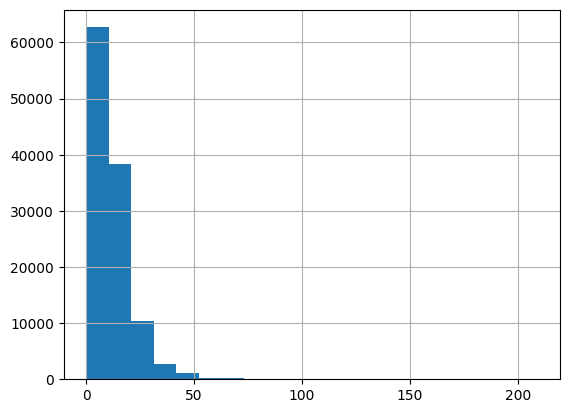

In [250]:
# 5.2.1 Distribution des délais de livraison
df_fact[df_fact["order_status"]=="delivered"]["delivery_time"].hist(bins=20)
plt.show()

In [251]:
# 5.2.2 - Delai de livraison par état
delivery_time_state = df_fact[df_fact["order_status"]=="delivered"].groupby("customer_state")["delivery_time"].mean()
display(delivery_time_state.reset_index())

,customer_state,delivery_time
0,AC,20.170213
1,AL,24.128090
2,AM,26.064706
3,AP,27.662651
4,BA,18.734684
5,CE,20.344415
6,DF,12.501430
7,ES,15.235116
8,GO,14.903967
9,MA,21.191981


In [253]:
# 5.2.2 - graphique delai de livraison par état
fig15 = px.bar(delivery_time_state.reset_index().sort_values(by="delivery_time",ascending=False), x="customer_state", y="delivery_time", title="Delai de livraison par état")
fig15.show()

In [254]:
# 5.2.3 - taux de livraison à temps et delais de livraison par état
delivery_time_state_rate = df_fact[df_fact["order_status"]=="delivered"].groupby("customer_state").agg(
    taux_livraison_a_temps=("delivery_vs_estimate", lambda x: (x<=0).mean()*100.0),
    delai_livraison_moyen=("delivery_time", "mean"))
display(delivery_time_state_rate.reset_index())

,customer_state,taux_livraison_a_temps,delai_livraison_moyen
0,AC,96.808511,20.170213
1,AL,78.651685,24.128090
2,AM,97.058824,26.064706
3,AP,96.385542,27.662651
4,BA,88.202532,18.734684
5,CE,86.569149,20.344415
6,DF,94.196976,12.501430
7,ES,89.344262,15.235116
8,GO,93.945720,14.903967
9,MA,82.138518,21.191981


In [257]:
# 5.2.3 - graphique taux de livraison à temps et delais de livraison par état
fig16 = px.scatter(delivery_time_state_rate.reset_index(), x="customer_state", y="taux_livraison_a_temps", size="delai_livraison_moyen",color="taux_livraison_a_temps", title="Taux de livraison à temps et delais de livraison par état")
fig16.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">3 - Visualisation avec plotly</h3>
</div>

# Qu'est ce que Plotly ?
Plotly est une bibliothèque de visualisation de données interactive qui permet de créer des graphiques et des visualisations dynamiques.
Elle est très populaire dans le domaine de l'analyse de données et de la data science .
Elle offre une grande flexibilité et permet de créer des visualisations complexes avec des interactions utilisateur.

Pour utiliser Plotly, il faut d'abord l'installer en utilisant la commande suivante :
```
pip install plotly
```
Pour créer un graphique avec Plotly, il faut d'abord importer la bibliothèque :
```
import plotly.express as px
```
ou
```
import plotly.graph_objects as go
```
- plotly.express est une interface de haut niveau qui permet de créer des graphiques avec une syntaxe simple.
Elle est idéale pour créer des visualisations rapidement et facilement.
- plotly.graph_objects est une interface de bas niveau qui permet de créer des graphiques avec une syntaxe plus détaillée.
Elle est idéale pour créer des visualisations complexes avec des interactions utilisateur.


## Visualisation avec plotly.express
plotly.express est une interface de haut niveau qui permet de créer des graphiques avec une syntaxe simple.
Elle est idéale pour créer des visualisations rapidement et facilement.

In [31]:
# graphique de la distribution des délais de livraison
px.histogram(data_frame=df_fact, x='delivery_time', nbins=20, title='Distribution des délais de livraison')

In [36]:
# graphique de la distribution des délais de livraison par état
px.histogram(data_frame=df_fact, x='delivery_time', color='customer_state', nbins=20, title='Distribution des délais de livraison par état')

In [37]:
# graphique des volumes de ventes par mois
df_vol = df_fact.groupby('order_month')['price'].sum().reset_index()
px.line(data_frame=df_vol, x='order_month', y='price', title='Volumes de ventes par mois')
